In [2]:
import torch
from utils import Normalise
from dataset import Simulation
import fk
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


filename = "/media/SSD1/epignatelli/train_dev_set/spiral_params5.hdf5"
fkset = Simulation(filename, 5, 5, 10, transform=Normalise())

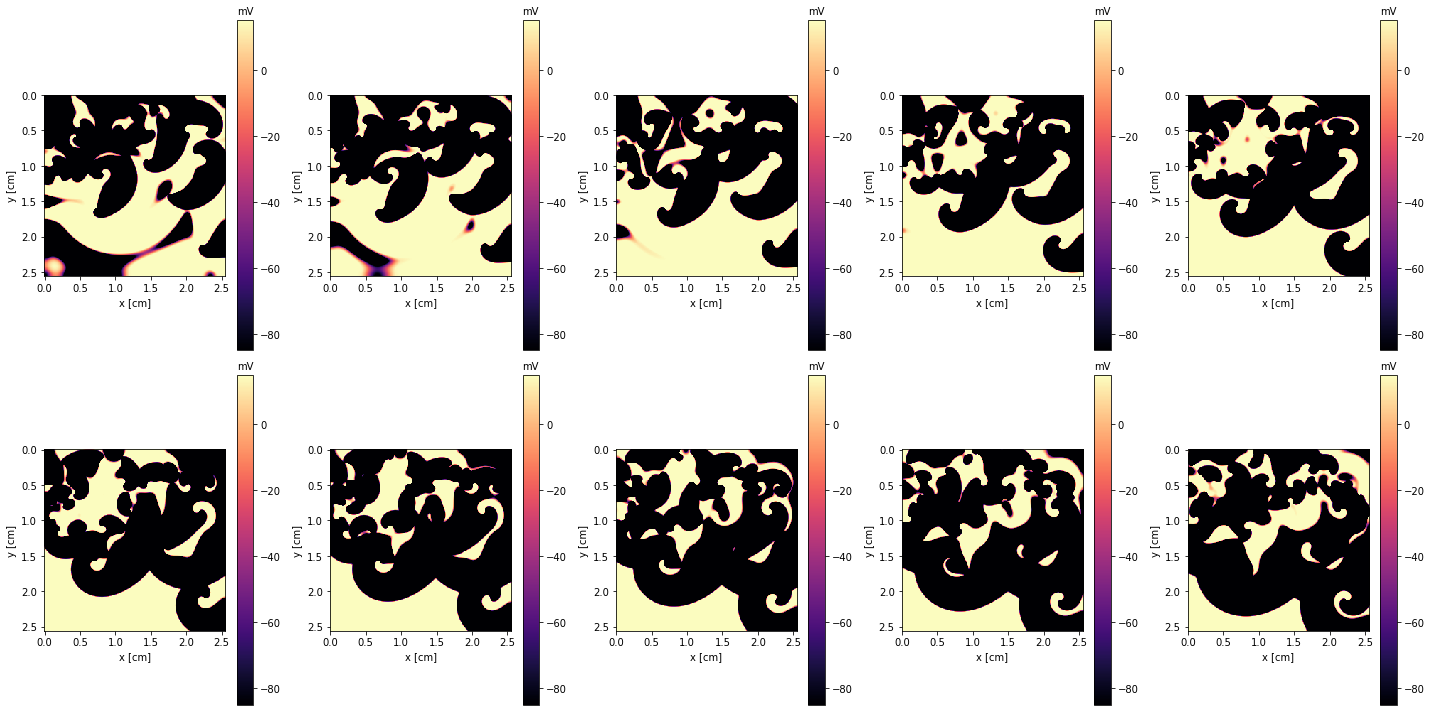

In [30]:
import random
i = random.choice(range(len(fkset)))
a = fk.plot.show_grid(fk.convert.u_to_V(fkset[i][:, 0]), figsize=(20, 10))

In [12]:
fkset[0].shape

(10, 3, 256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


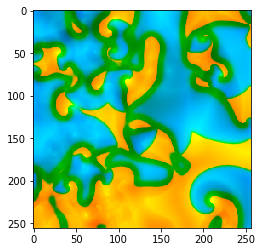

In [30]:
plt.imshow(fkset[1500].squeeze().transpose(2, 1, 0))

In [1]:
import torch
a = torch.randn(32, 15, 3, 256, 254)
torch.transpose(a, -2, -1).shape

torch.Size([32, 15, 3, 254, 256])